In [1]:
library(dplyr)
library(ggplot2)
library(tseries)
library(rugarch)
library(MASS)
library(latex2exp)

Warning message:
"pakiet 'dplyr' został zbudowany w wersji R 4.2.2"

Dołączanie pakietu: 'dplyr'


Następujące obiekty zostały zakryte z 'package:stats':

    filter, lag


Następujące obiekty zostały zakryte z 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"pakiet 'ggplot2' został zbudowany w wersji R 4.2.2"
Warning message:
"pakiet 'tseries' został zbudowany w wersji R 4.2.2"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"pakiet 'rugarch' został zbudowany w wersji R 4.2.3"
Ładowanie wymaganego pakietu: parallel


Dołączanie pakietu: 'rugarch'


Następujący obiekt został zakryty z 'package:stats':

    sigma


Warning message:
"pakiet 'MASS' został zbudowany w wersji R 4.2.3"

Dołączanie pakietu: 'MASS'


Następujący obiekt został zakryty z 'package:dplyr':

    select


Warning message:
"pakiet 'latex2exp' został zbudowany w wersji R 4.2.2"


In [2]:
emp_ACVF <- function(X,h){
    n <- length(X)
    xm <- mean(X)
    X1 <- X[1:(n-abs(h))]
    X2 <- X[(1+abs(h)):n]
    return(1/n*sum((X1-xm)*(X2-xm)))
}

In [3]:
emp_acorr <- function(X,h){
    Z <- emp_ACVF(X,h)
    Y <- emp_ACVF(X,0)
    return(Z/Y)
}

# Wstępne przedstawienie danych

In [4]:
Xt <- read.csv('wroclaw_notrend_noseason.csv')[,2:5]

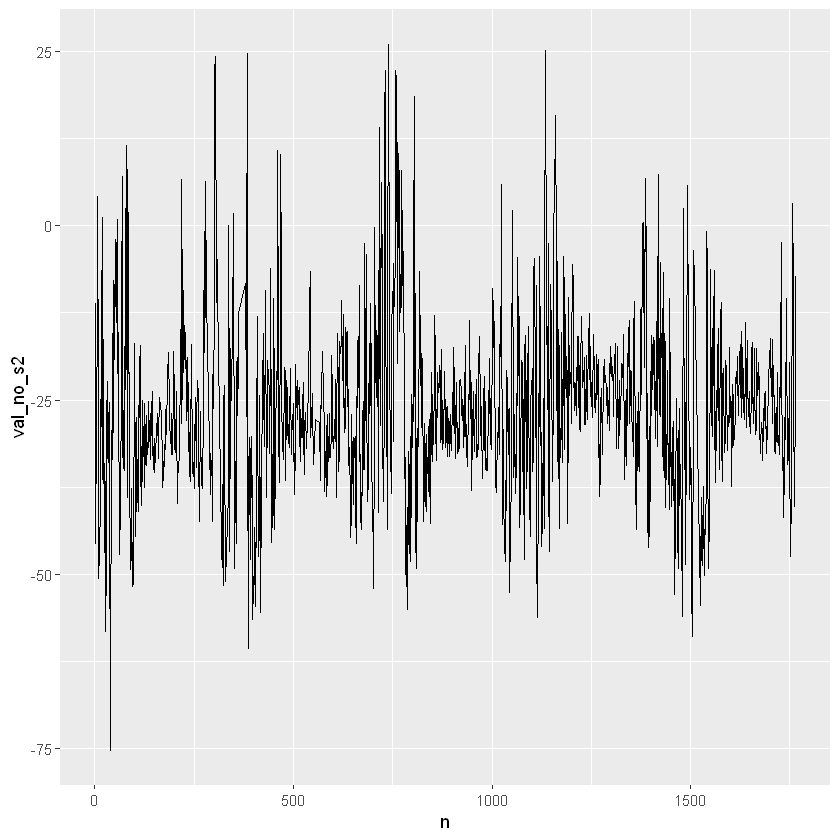

In [5]:
ggplot(Xt, aes(n, val_no_s2))+geom_line()

In [8]:
h <- 1:1000
corr1 <- c()
for(i in h) corr1[i] <- emp_acorr(Xt$val_no_s2,i)
df_h <- data.frame(h,corr1)

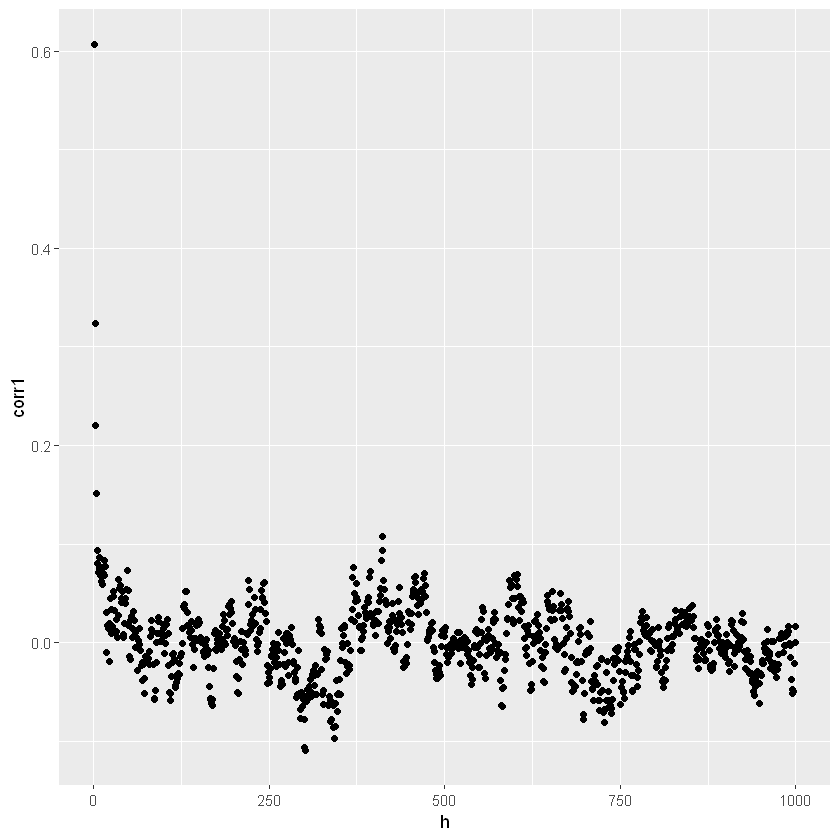

In [9]:
ggplot(df_h, aes(h,corr1))+geom_point()

# Dopasowanie rozkładu

In [10]:
fitdistr(Xt$val_no_s2, 'logistic')

    location        scale   
  -26.8877266     6.2711475 
 (  0.2652505) (  0.1315023)

## Test na poziomie istotnosci $\alpha=0.05$

In [11]:
ks.test(Xt$val_no_s2, 'plogis', loc=-26.89, scale=6.27)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  Xt$val_no_s2
D = 0.032191, p-value = 0.06737
alternative hypothesis: two-sided


### P-value $= 0.06737 > 0.05$ zatem nie ma podstaw do odrzucenia hipotezy zerowej 

## Dopasowanie modelu ARMA(1,2)-GARCH(1,1)

https://quant.stackexchange.com/questions/4948/how-to-fit-armagarch-model-in-r

In [12]:
spec <- ugarchspec(variance.model = list(model = "sGARCH", 
                                         garchOrder = c(1, 1), 
                                         submodel = NULL, 
                                         external.regressors = NULL, 
                                         variance.targeting = FALSE), 

                   mean.model     = list(armaOrder = c(1, 2), 
                                         external.regressors = NULL, 
                                         distribution.model = "logis", 
                                         start.pars = list(), 
                                         fixed.pars = list()))

garch <- ugarchfit(spec = spec, data = Xt$val_no_s2, solver.control = list(trace=0))

Warning message:
"unidentified option(s) in mean.model:
 distribution.model start.pars fixed.pars"


In [13]:
garch@fit$coef

mu          ar1          ma1          ma2        omega       alpha1 
-26.23154107   0.67013009  -0.02328254  -0.12241391   0.65889895   0.10072098 
       beta1 
  0.89533134

## Przykładowa symulacja dopasowanego modelu

In [14]:
garch_sim <- ugarchsim(garch,n.sim=1636, startMethod='sample')

In [15]:
sp_sim <- garch_sim@simulation$seriesSim

In [16]:
Xt$simulated <- sp_sim

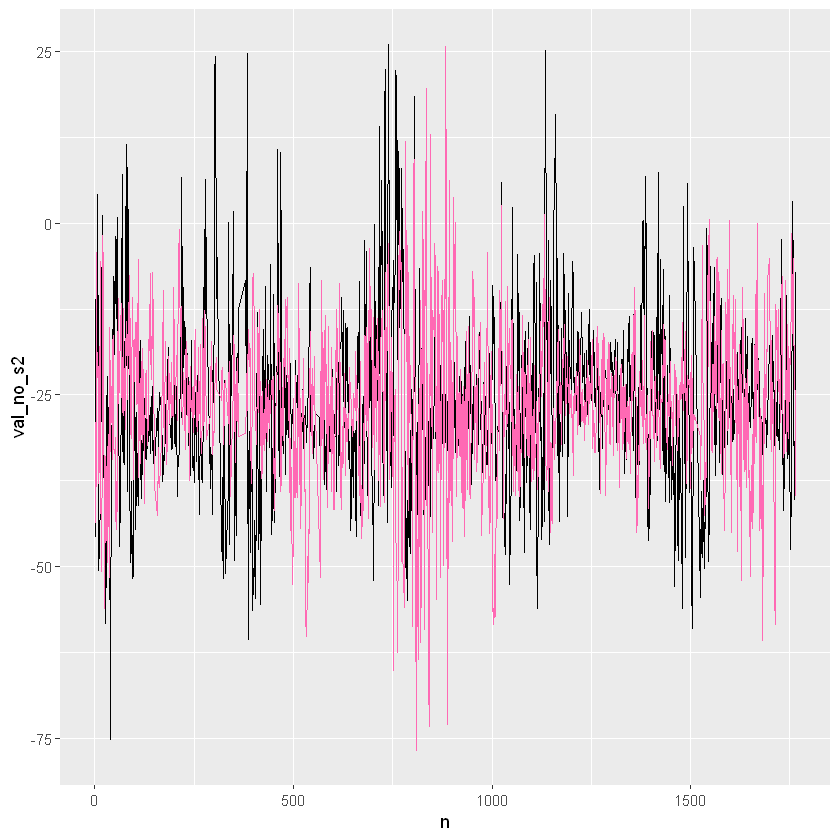

In [17]:
ggplot(Xt, aes(n))+geom_line(aes(y=val_no_s2))+geom_line(aes(y=simulated), col='hotpink')

# Linie kwantylowe

In [18]:
trajectories <- matrix(0,nrow=1000, ncol=1636)
for(i in 1:1000) trajectories[i,] <- ugarchsim(garch,n.sim=1636, startMethod='sample')@simulation$seriesSim

In [29]:
quant_5 <- c()
for(i in 1:1636) quant_5[i] <- quantile(trajectories[,i],0.05)
quant_95 <- c()
for(i in 1:1636) quant_95[i] <- quantile(trajectories[,i],0.95)
quant_10 <- c()
for(i in 1:1636) quant_10[i] <- quantile(trajectories[,i],0.1)
quant_90 <- c()
for(i in 1:1636) quant_90[i] <- quantile(trajectories[,i],0.9)
quant_20 <- c()
for(i in 1:1636) quant_20[i] <- quantile(trajectories[,i],0.2)
quant_80 <- c()
for(i in 1:1636) quant_80[i] <- quantile(trajectories[,i],0.8)
quant_30 <- c()
for(i in 1:1636) quant_30[i] <- quantile(trajectories[,i],0.3)
quant_70 <- c()
for(i in 1:1636) quant_70[i] <- quantile(trajectories[,i],0.7)
quant_40 <- c()
for(i in 1:1636) quant_40[i] <- quantile(trajectories[,i],0.4)
quant_60 <- c()
for(i in 1:1636) quant_60[i] <- quantile(trajectories[,i],0.6)

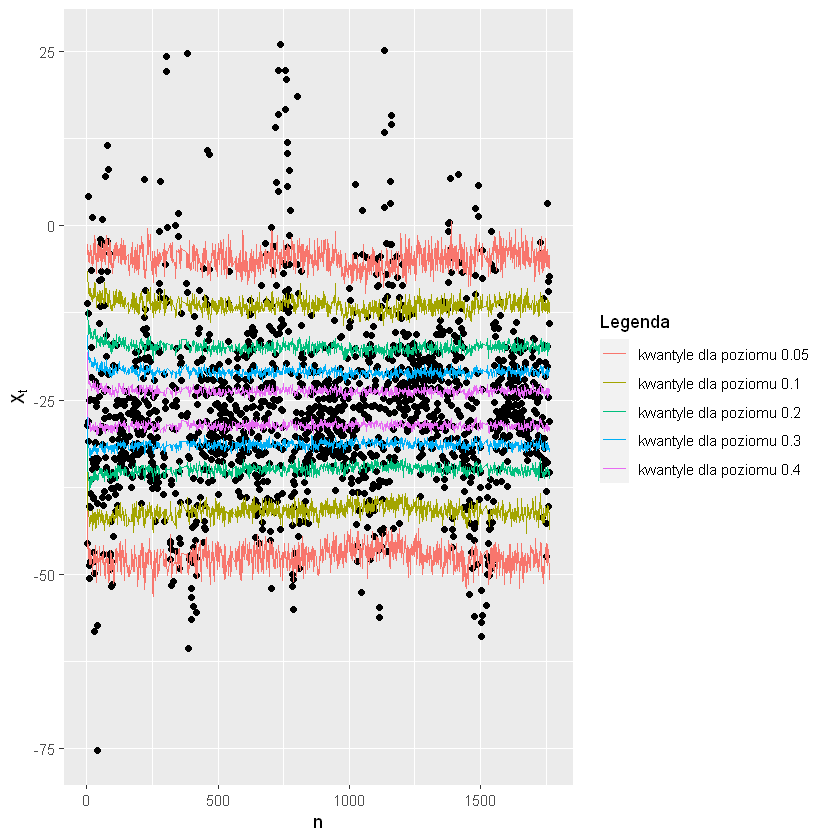

In [30]:
quantile_lines <- ggplot(Xt, aes(n,val_no_s2))+
    geom_point()+ylab(TeX('$X_t$'))+
    geom_line(aes(y=quant_5,col='kwantyle dla poziomu 0.05'))+
    geom_line(aes(y=quant_95,col='kwantyle dla poziomu 0.05'))+
    geom_line(aes(y=quant_10,col='kwantyle dla poziomu 0.1'))+
    geom_line(aes(y=quant_90,col='kwantyle dla poziomu 0.1'))+
    geom_line(aes(y=quant_20,col='kwantyle dla poziomu 0.2'))+
    geom_line(aes(y=quant_80,col='kwantyle dla poziomu 0.2'))+
    geom_line(aes(y=quant_30,col='kwantyle dla poziomu 0.3'))+
    geom_line(aes(y=quant_70,col='kwantyle dla poziomu 0.3'))+
    geom_line(aes(y=quant_40,col='kwantyle dla poziomu 0.4'))+
    geom_line(aes(y=quant_60,col='kwantyle dla poziomu 0.4'))+
    #scale_color_manual(values=c('palevioletred2','palevioletred4'))+
    guides(col=guide_legend(title="Legenda"))
quantile_lines

In [31]:
prob5 <- 0
prob10 <- 0
prob20 <- 0
prob30 <- 0
prob40 <- 0
for(i in 1:1636){
    X <- Xt$val_no_s2[i]
    if(X>quant_5[i] & X<quant_95[i]) prob5 <- prob5+1
    if(X>quant_10[i] & X<quant_90[i]) prob10 <- prob10+1
    if(X>quant_20[i] & X<quant_80[i]) prob20 <- prob20+1
    if(X>quant_30[i] & X<quant_70[i]) prob30 <- prob30+1
    if(X>quant_40[i] & X<quant_60[i]) prob40 <- prob40+1
}

In [32]:
probs <- data.frame(prob5,prob10,prob20,prob30,prob40)
probs/1636

prob5,prob10,prob20,prob30,prob40
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.9132029,0.8227384,0.643643,0.4193154,0.2059902
